<a href="https://colab.research.google.com/github/REPANAJYOTHIPRAKASH629/SPARKTECHNOIT/blob/main/road_lane_line_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

108 897


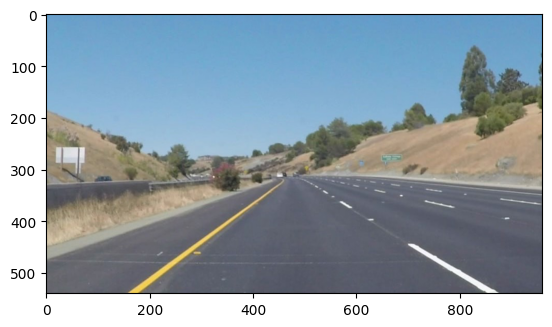

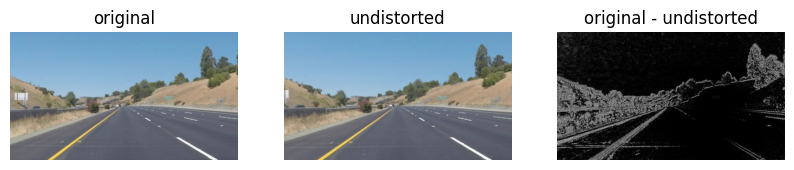

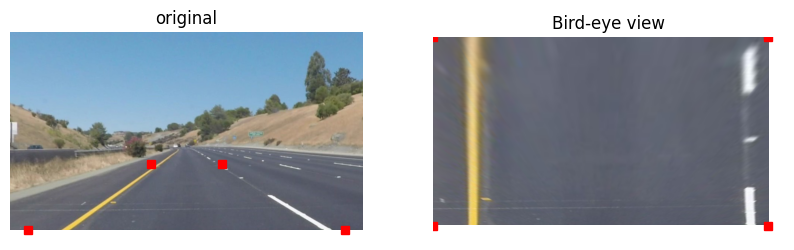

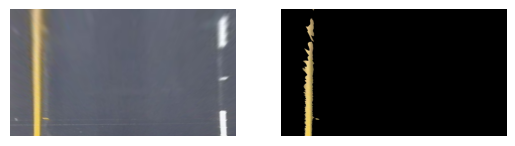

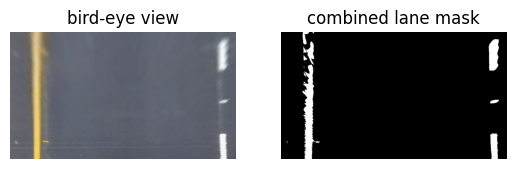

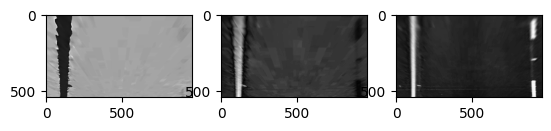

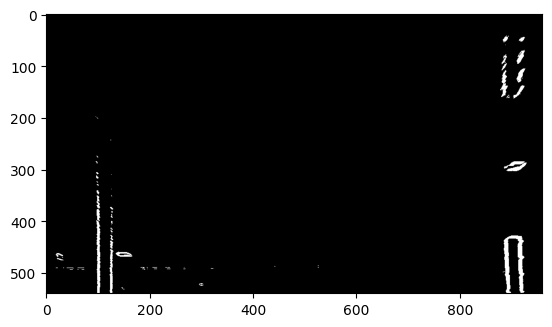

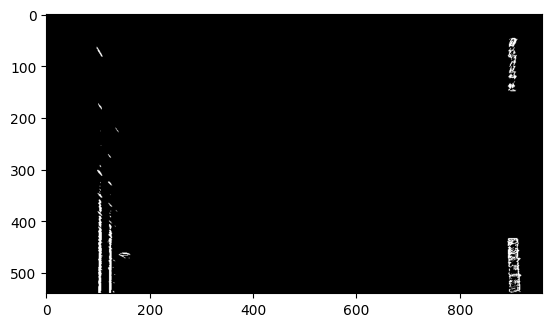

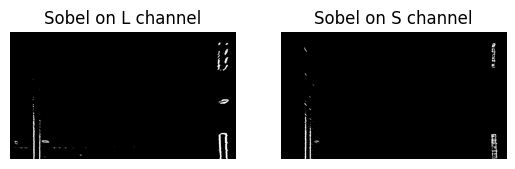

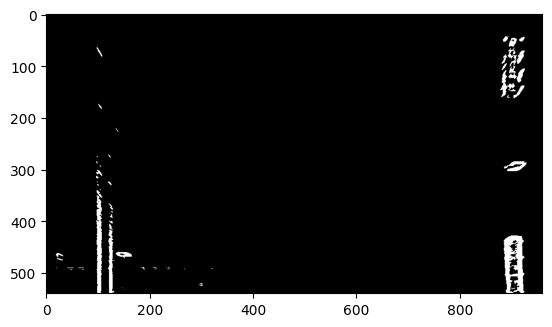

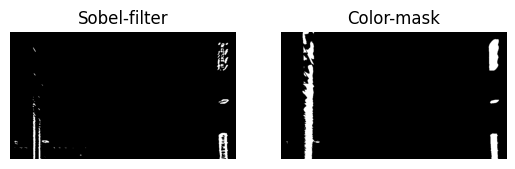

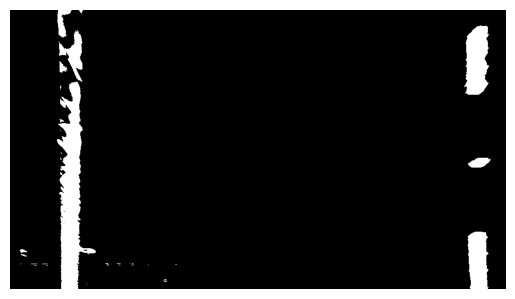

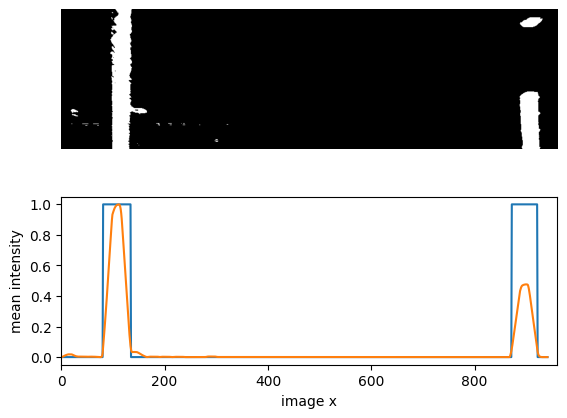

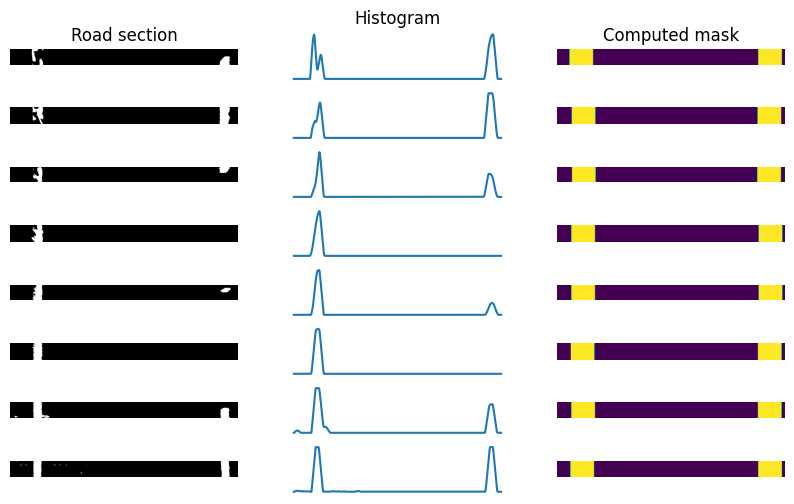

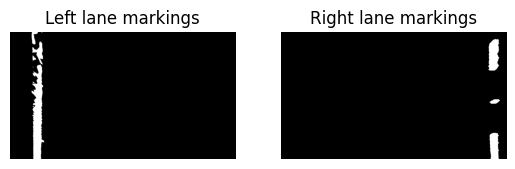

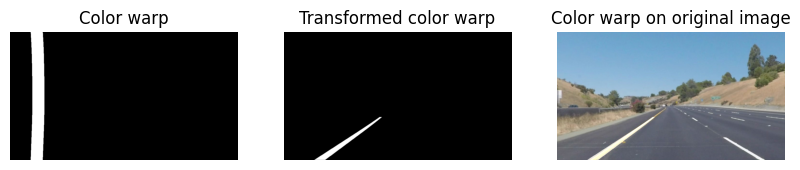

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
from scipy.signal import find_peaks_cwt

#=======================================================================================================================
"""
Global Definition
"""
#=======================================================================================================================

pi = 3.14159
data = pickle.load( open( "/content/camera_calibration.pkl", "rb" ))
mtx_camera = data[0]
dist_camera = data[1]

# Define kernel size for filters
kernel_size = 5
window_size = 60

#reading in an image
image = mpimg.imread('/content/original_image.jpeg')
plt.imshow(image)

#=======================================================================================================================
"""
Functional Inherit
"""
#=======================================================================================================================

def get_initial_mask(img, window_sz):
    # This function gets the initial mask

    img = gaussian_blur(img, 5)
    img_size = np.shape(img)
    mov_filtsize = img_size[1] / 50.
    mean_ln = np.mean(img[img_size[0] / 2:, :], axis=0)
    mean_ln = moving_average(mean_ln, mov_filtsize)

    indexes = find_peaks_cwt(mean_ln, [100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes))])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR < ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp
    mask_L_i = np.zeros_like(img)
    mask_R_i = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL

    # Split image into 8 parts and compute histogram on each part

    for i in range(8):
        img_y1 = img_size[0] - img_size[0] * i / 8
        img_y2 = img_size[0] - img_size[0] * (i + 1) / 8

        mean_lane_y = np.mean(img[img_y2:img_y1, :], axis=0)
        mean_lane_y = moving_average(mean_lane_y, mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y, [100], max_distances=[800])

        if len(indexes) > 1.5:
            val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes))])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR < ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp

        else:
            # If no pixels are found, use previous ones.
            if len(indexes) == 1:
                if (np.abs(indexes[0] - ind_peakR_prev) < np.abs(indexes[0] - ind_peakL_prev)):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev
            else:
                ind_peakL = ind_peakL_prev
                ind_peakR = ind_peakR_prev

        # If new center is more than 60pixels away, use previous
        # Outlier rejection
        if np.abs(ind_peakL - ind_peakL_prev) >= 60:
            ind_peakL = ind_peakL_prev

        if np.abs(ind_peakR - ind_peakR_prev) >= 60:
            ind_peakR = ind_peakR_prev

        mask_L_i[img_y2:img_y1, ind_peakL - window_sz:ind_peakL + window_sz] = 1.
        mask_R_i[img_y2:img_y1, ind_peakR - window_sz:ind_peakR + window_sz] = 1.

        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR

    return mask_L_i, mask_R_i


def get_mask_poly(img, poly_fit, window_sz):
    # This function returns masks for points used in computing polynomial fit.
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = img_size[0] - img_size[0] * i / 8
        img_y2 = img_size[0] - img_size[0] * (i + 1) / 8

        pt_y = (img_y1 + img_y2) / 2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0] * pt_y ** 2 + poly_fit[1] * pt_y + poly_fit[2])

        poly_pts.append(poly_pt)

        mask_poly[img_y2:img_y1, poly_pt - window_sz:poly_pt + window_sz] = 1.

    return mask_poly, np.array(poly_pts), np.array(pt_y_all)


def get_val(y, pol_a):
    # Returns value of a quadratic polynomial
    return pol_a[0] * y ** 2 + pol_a[1] * y + pol_a[2]


def draw_pw_lines(img, pts, color):
    # This function draws lines connecting 10 points along the polynomial
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i + 1][0]
        y2 = pts[0][i + 1][1]
        cv2.line(img, (x1, y1), (x2, y2), color, 50)


def undistort_image(img, mtx, dist):
    # Function to undistort image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img


def gaussian_blur(img, kernel=5):
    # Function to smooth image
    blur = cv2.GaussianBlur(img, (kernel, kernel), 0)
    return blur


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient == 'x':
        img_s = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255 * img_abs / np.max(img_abs))

    binary_output = 0 * img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img, cv2.CV_64F, 0, 1)

    img_s = np.sqrt(img_sx ** 2 + img_sy ** 2)
    img_s = np.uint8(img_s * 255 / np.max(img_s))
    binary_output = 0 * img_s
    binary_output[(img_s >= thresh[0]) & (img_s <= thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))

    binary_output = 0 * grad_s  # Remove this line
    binary_output[(grad_s >= thresh[0]) & (grad_s <= thresh[1])] = 1
    return binary_output


def GaussianC_Adaptive_Threshold(img, kernel, cut_val):
    # Gaussian adaptive thresholding (NOT USED )
    img_cut = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                    cv2.THRESH_BINARY, kernel, cut_val)
    return img_cut


def warp_image(img, src, dst, img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv


def sobel_combined(image):
    # Combine sobel masks.
    img_g_mag = mag_thresh(image, 3, (20, 150))
    img_d_mag = dir_threshold(image, 3, (.6, 1.1))
    img_abs_x = abs_sobel_thresh(image, 'x', 5, (50, 200))
    img_abs_y = abs_sobel_thresh(image, 'y', 5, (50, 200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
                   ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def color_mask(hsv, low, high):
    # Takes in low and high values and returns mask
    mask = cv2.inRange(hsv, low, high)
    return mask


def apply_color_mask(hsv, img, low, high):
    # Takes in color mask and returns image with mask applied.
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img, img, mask=mask)
    return res


def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_initial_mask(img, window_size):
    img = gaussian_blur(img, 5)
    img_size = np.shape(img)
    mov_filtsize = img_size[1] / 20.
    mean_ln = np.mean(img[int(img_size[0] / 2):, :], axis=0)
    mean_ln = moving_average(mean_ln, int(mov_filtsize))

    indexes = find_peaks_cwt(mean_lane, [100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes))])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR < ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL - window_size
    ind_max_L = ind_peakL + window_size

    ind_min_R = ind_peakR - window_size
    ind_max_R = ind_peakR + window_size

    mask_L_poly = np.zeros_like(img)
    mask_R_poly = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL

    diff_R = 0
    diff_L = 0
    for i in range(8):

        img_y1 = img_size[0] - img_size[0] * i / 8
        img_y2 = img_size[0] - img_size[0] * (i + 1) / 8

        mean_lane_y = np.mean(img[int(img_y2):int(img_y1), :], axis=0)
        mean_lane_y = moving_average(mean_lane_y, int(mov_filtsize))
        indexes = find_peaks_cwt(mean_lane_y, [100], max_distances=[800])

        if len(indexes) > 1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes))])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR < ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp

        else:
            if len(indexes) == 1:
                if np.abs(indexes[0] - ind_peakR_prev) < np.abs(indexes[0] - ind_peakL_prev):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev + diff_R
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev + diff_R
            else:
                ind_peakL = ind_peakL_prev + diff_R
                ind_peakR = ind_peakR_prev + diff_R

        if np.abs(ind_peakL - ind_peakL_prev) >= 100:
            ind_peakL = ind_peakL_prev
        if np.abs(ind_peakR - ind_peakR_prev) >= 100:
            ind_peakR = ind_peakR_prev

        mask_L_poly[int(img_y2):int(img_y1), int(ind_peakL - window_size):int(ind_peakL + window_size)] = 1.
        mask_R_poly[int(img_y2):int(img_y1), int(ind_peakR - window_size):int(ind_peakR + window_size)] = 1.

        if i == 0:
            window_size = window_size / 1

        if i > 0:
            diff_R = ind_peakL - ind_peakL_prev
            diff_L = ind_peakR - ind_peakR_prev

        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR

    return mask_L_poly, mask_R_poly
#=======================================================================================================================
"""
Implementation
Image distortion removal
"""
#=======================================================================================================================

image_ud = undistort_image(image, mtx_camera , dist_camera )
plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2),cmap='gray')
plt.title('original - undistorted')
plt.axis('off')

#=======================================================================================================================
"""
Perspective transform
"""
#=======================================================================================================================

image = image_ud
img_size = np.shape(image)
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - .9*np.uint(img_size[1]/2)
cbr_window = c_window + .9*np.uint(img_size[1]/2)
src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
for i in range(4):
    plt.plot(src[i][0], src[i][1], 'rs')
plt.title('original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(warped, cmap='gray')
for i in range(4):
    plt.plot(dst[i][0], dst[i][1], 'rs')

plt.title('Bird-eye view')
plt.axis('off')

#=======================================================================================================================
"""
Color Mask
"""
#=======================================================================================================================
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])


res_mask = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)

res = apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(warped)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res)
plt.axis('off');

#=======================================================================================================================
"""
Bird eye view
"""
#=======================================================================================================================
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)


white_hsv_low  = np.array([ 0,   0,   160])
white_hsv_high = np.array([ 255,  80, 255])

res1 = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('bird-eye view')
plt.axis('off');

#=======================================================================================================================
"""
Combined Mask
"""
#=======================================================================================================================
mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask')
plt.axis('off')

plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2],cmap='gray')


#=======================================================================================================================
"""
Sobel Filter
"""
#=======================================================================================================================
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,1]
sobel_c = sobel_combined(img_gs)
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
plt.figure()
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

img_gs = image_HLS[:,:,2]
sobel_c = sobel_combined(img_gs)
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
plt.figure()
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

#=======================================================================================================================
"""
Combine Sobel filter for Right and Left lane
"""
#=======================================================================================================================
wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(wraped2,cmap='gray')
plt.title('Sobel on L channel')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Sobel on S channel')
plt.imshow(wraped3,cmap='gray')
plt.axis('off');
image_cmb = cv2.bitwise_or(wraped2,wraped3)
image_cmb = gaussian_blur(image_cmb,3)
plt.figure()
plt.imshow(image_cmb,cmap='gray')

#=======================================================================================================================
"""
Combined Sobel filter
"""
#=======================================================================================================================
image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter')
plt.subplot(1,2,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('Color-mask')

plt.figure()
plt.imshow(gaussian_blur(image_cmb1,1),cmap='gray')
plt.axis('off')


#=======================================================================================================================
"""
Isolate Lane
"""
#=======================================================================================================================

mov_filtsize = img_size[1]/50.
mean_lane = np.mean(image_cmb1[int(img_size[0]/2):,:],axis=0)
mean_lane = moving_average(mean_lane,int(mov_filtsize))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(image_cmb1[int(img_size[0]/2):,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])

#=======================================================================================================================
"""
Find peak value from isolated lanes
"""
#=======================================================================================================================
indexes = find_peaks_cwt(mean_lane, [100], max_distances=[800])
window_size = 50
val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes))])
ind_sorted = np.argsort(-val_ind)

ind_peakR = indexes[ind_sorted[0]]
ind_peakL = indexes[ind_sorted[1]]
if ind_peakR < ind_peakL:
    ind_temp = ind_peakR
    ind_peakR = ind_peakL
    ind_peakL = ind_temp

n_vals = 8

# Get windows for bottom frame
ind_min_L = ind_peakL - 50
ind_max_L = ind_peakL + 50

ind_min_R = ind_peakR - 50
ind_max_R = ind_peakR + 50

mask_L_poly = np.zeros_like(image_cmb1)
mask_R_poly = np.zeros_like(image_cmb1)
print(ind_peakL, ind_peakR)
ind_peakR_prev = ind_peakR
ind_peakL_prev = ind_peakL

plt.figure(figsize=(10, 6))
# Slide window up for each 1/8th of image
for i in range(8):
    img_y1 = img_size[0] - img_size[0] * i / 8
    img_y2 = img_size[0] - img_size[0] * (i + 1) / 8

    mean_lane_y = np.mean(image_cmb1[int(img_y2):int(img_y1), :], axis=0)
    mean_lane_y = moving_average(mean_lane_y, int(mov_filtsize))
    indexes = find_peaks_cwt(mean_lane_y, [100], max_distances=[800])

    # If 2 peaks are detected assign peaks to correct side.

    if len(indexes) > 1.5:
        val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes))])
        ind_sorted = np.argsort(-val_ind)

        ind_peakR = indexes[ind_sorted[0]]
        ind_peakL = indexes[ind_sorted[1]]
        if ind_peakR < ind_peakL:
            ind_temp = ind_peakR
            ind_peakR = ind_peakL
            ind_peakL = ind_temp

    else:
        # If 1 peak is detected, assign peak to closest peak in previous 1/8th image.
        if len(indexes) == 1:
            if np.abs(indexes[0] - ind_peakR_prev) < np.abs(indexes[0] - ind_peakL_prev):
                ind_peakR = indexes[0]
                ind_peakL = ind_peakL_prev
            else:
                ind_peakL = indexes[0]
                ind_peakR = ind_peakR_prev
        else:
            ind_peakL = ind_peakL_prev
            ind_peakR = ind_peakR_prev

    if np.abs(ind_peakL - ind_peakL_prev) >= 100:
        ind_peakL = ind_peakL_prev
    if np.abs(ind_peakR - ind_peakR_prev) >= 100:
        ind_peakR = ind_peakR_prev

    mask_L_poly[int(img_y2):int(img_y1), ind_peakL - window_size:ind_peakL + window_size] = 1.
    mask_R_poly[int(img_y2):int(img_y1), ind_peakR - window_size:ind_peakR + window_size] = 1.

    ind_peakL_prev = ind_peakL
    ind_peakR_prev = ind_peakR

    plt.subplot(8, 3, 25 - 3 * i - 2)
    plt.plot(mean_lane_y)
    if i == 7:
        plt.title('Histogram')
    plt.axis('off')
    plt.subplot(8, 3, 25 - 3 * i - 3)
    plt.imshow(image_cmb1[int(img_y2):int(img_y1), :], cmap='gray')
    if i == 7:
        plt.title('Road section')
    plt.axis('off')
    plt.subplot(8, 3, 25 - 3 * i - 1)
    plt.imshow(mask_L_poly[int(img_y2):int(img_y1), :] + mask_R_poly[int(img_y2):int(img_y1), :])
    plt.axis('off')
    if i == 7:
        plt.title('Computed mask')

#=======================================================================================================================
"""
isolate left and right lane
"""
#=======================================================================================================================
mask_L_poly,mask_R_poly = get_initial_mask(image_cmb1,50)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mask_R_poly+ mask_L_poly)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cv2.bitwise_and(image_cmb1,image_cmb1,mask=mask_R_poly+mask_L_poly),cmap='gray')

#=======================================================================================================================
"""
apply masking for left and right lane
"""
#=======================================================================================================================
mask_L = mask_L_poly

img_L = np.copy(image_cmb1)
img_L = cv2.bitwise_and(img_L,img_L,mask=mask_L_poly)


mask_R = mask_R_poly

img_R = np.copy(image_cmb1)
img_R = cv2.bitwise_and(img_R,img_R,mask=mask_R_poly)
img_L = gaussian_blur(img_L,5)

plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.axis('off')
plt.title('Left lane markings')
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.axis('off')
plt.title('Right lane markings')


#=======================================================================================================================
"""
color wrap
"""
#=======================================================================================================================
vals = np.argwhere(img_R>.5)

vals = np.argwhere(img_L>.5)
all_x = vals.T[0]
all_y =vals.T[1]

left_fit = np.polyfit(all_x, all_y, 2)
left_y = np.arange(11)*img_size[0]/10
left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
all_x = vals.T[0]
all_y =vals.T[1]

right_fit = np.polyfit(all_x, all_y, 2)
right_y = np.arange(11)*img_size[0]/10
right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

#=======================================================================================================================
"""
Color wrapping on original image
"""
#=======================================================================================================================

warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))


cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

col_L = (255,255,0)
col_R = (255,255,255)

draw_pw_lines(color_warp,np.int_(pts_left),col_L)
draw_pw_lines(color_warp,np.int_(pts_right),col_R)


newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0]))
result = cv2.addWeighted(image_ud, 1, newwarp, 0.5, 0)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')
plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on original image')
plt.axis('off')

result = cv2.addWeighted(image_ud, 1, newwarp, 0.5, 0)
plt.show()